## Update
- Use UpSample2d+Conv2d instead of ConvTrans2D, see comments for detail
- Add Batch Normalization layer after each conv
- You can use crf method (https://www.kaggle.com/meaninglesslives/apply-crf) to improve the result 
## Changelog
- Changed uncov to uconv, but removed the dropout in the last layer
- Corrected sanity check of predicted validation data (changed from ids_train to ids_valid)
- Used correct mask (from original train_df) for threshold tuning (inserted y_valid_ori)

# About
Since I am new to learning from image segmentation and kaggle in general I want to share my noteook.
I saw it is similar to others as it uses the U-net approach. I want to share it anyway because:

- As said, the field is new to me so I am open to suggestions.
- It visualizes some of the steps, e.g. scaling, to learn if the methods do what I expect which might be useful to others (I call them sanity checks).
- Added stratification by the amount of salt contained in the image.
- Added augmentation by flipping the images along the y axes (thanks to the forum for clarification).
- Added dropout to the model which seems to improve performance.

In [143]:
from __future__ import division
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook

# Params and helpers

In [453]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]
    
def img_mask_plot(img,mask):
    fix, axs = plt.subplots(1, 2, figsize=(10,10))
    axs[0].imshow(img.squeeze(), cmap="Greys")
    axs[0].set_title("Image")

    axs[1].imshow(mask.squeeze(), cmap="Greys")
    axs[1].set_title("Mask")
    
def img_3_plot(img1,img2,img3,tit="",tits=["Img1","Img2","Img3"]):
    fix, axs = plt.subplots(1, 3, figsize=(8,8))
    fix.suptitle(tit,fontsize=10)
    axs[0].imshow(img1.squeeze(), cmap="Greys")
    axs[0].set_title(tits[0])
    axs[1].imshow(img2.squeeze(), cmap="Greys")
    axs[1].set_title(tits[1])
    axs[2].imshow(img3.squeeze(), cmap="Greys")
    axs[2].set_title(tits[2])
    fix.subplots_adjust(top=1.5)
    plt.show()

def iou_clean_old(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return iou

def iou_clean(y_true_in, y_pred_in):
    intr = np.sum((y_true_in+y_pred_in)==2)
    unio = np.sum(y_true_in+y_pred_in)-intr
    if unio == 0:
        ret = 1
    else:
        ret = intr/unio
    return ret

def prec_clean(y_true_in, y_pred_in):
    tp = np.sum((y_true_in+y_pred_in)==2)
    fp = np.sum(y_true_in == (y_pred_in+1))
    fn = np.sum(y_true_in == (y_pred_in-1))
    sum_p = tp+fp+fn
    if sum_p == 0:
        pr = 1
    else:
        pr = tp/sum_p
    return pr
    

def iou_clean_batch(y_true_in, y_pred_in):
    import numpy as np
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_clean(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(metric)

def prec_clean_batch(y_true_in, y_pred_in):
    import numpy as np
    batch_size = y_true_in.shape[0]
    prec = []
    for batch in range(batch_size):
        value = prec_clean(y_true_in[batch], y_pred_in[batch])
        prec.append(value)
    return np.array(prec)



# Loading of training/testing ids and depths
Reading the training data and the depths, store them in a DataFrame. Also create a test DataFrame with entries from depth not in train.

In [3]:
train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

# Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [145]:
train_df["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

HBox(children=(IntProgress(value=0, max=4000), HTML(value=u'')))

In [146]:
train_df["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

HBox(children=(IntProgress(value=0, max=4000), HTML(value=u'')))

In [144]:
10/255

0.0392156862745098

# Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only.
Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [147]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [148]:
n_cl = 10
def cov_to_class(val):    
    for i in range(0, 1+n_cl):
        if val * n_cl <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

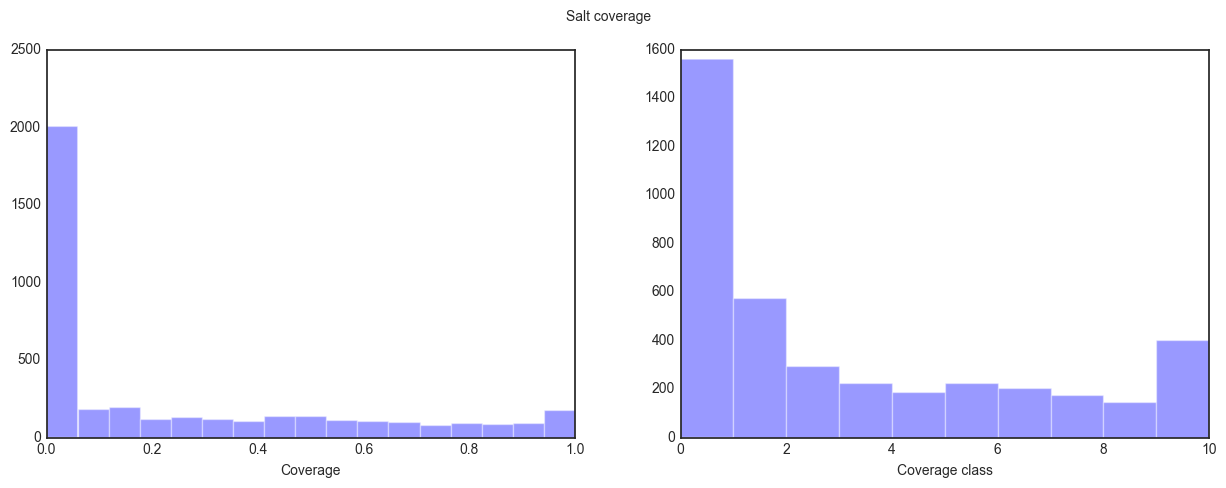

In [149]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=n_cl, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

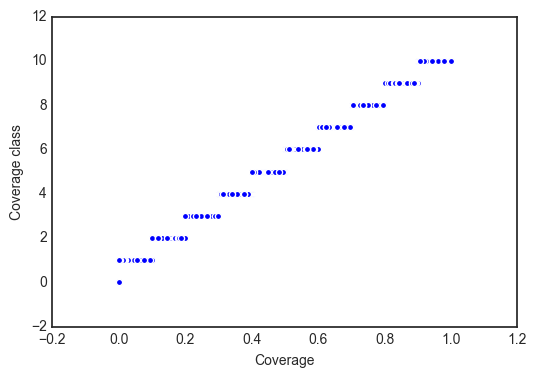

In [150]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage class")

# Plotting the depth distributions
Separatelty plotting the depth distributions for the training and the testing data.

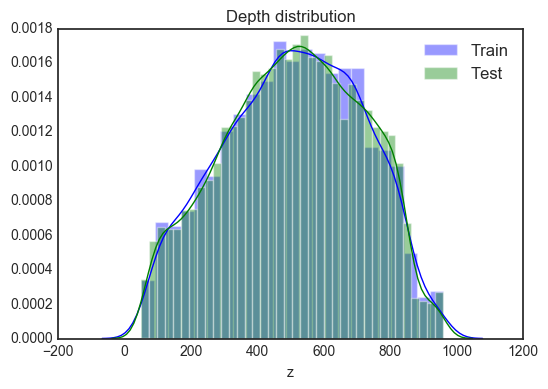

In [151]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

# Show some example images

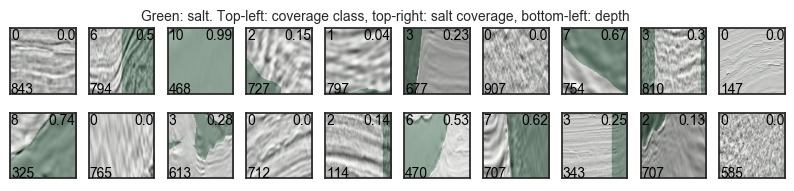

In [152]:
max_images = 20
grid_width = 10
plot_class = 1
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
#for i, idx in enumerate(train_df[train_df.coverage_class==plot_class].index[:max_images]):
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [153]:
train_df.iloc[0].images

array([[0.5254902 , 0.51372549, 0.5254902 , ..., 0.5254902 , 0.53333333,
        0.53333333],
       [0.48627451, 0.48235294, 0.4745098 , ..., 0.52156863, 0.48627451,
        0.4745098 ],
       [0.44705882, 0.4627451 , 0.45490196, ..., 0.5372549 , 0.50196078,
        0.47843137],
       ...,
       [0.69803922, 0.69803922, 0.68627451, ..., 0.47058824, 0.47058824,
        0.49411765],
       [0.70588235, 0.70196078, 0.69411765, ..., 0.42745098, 0.43921569,
        0.46666667],
       [0.71372549, 0.69803922, 0.69803922, ..., 0.37647059, 0.38823529,
        0.41176471]])

# Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion. Also show an image to check for correct upsampling.

In [154]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

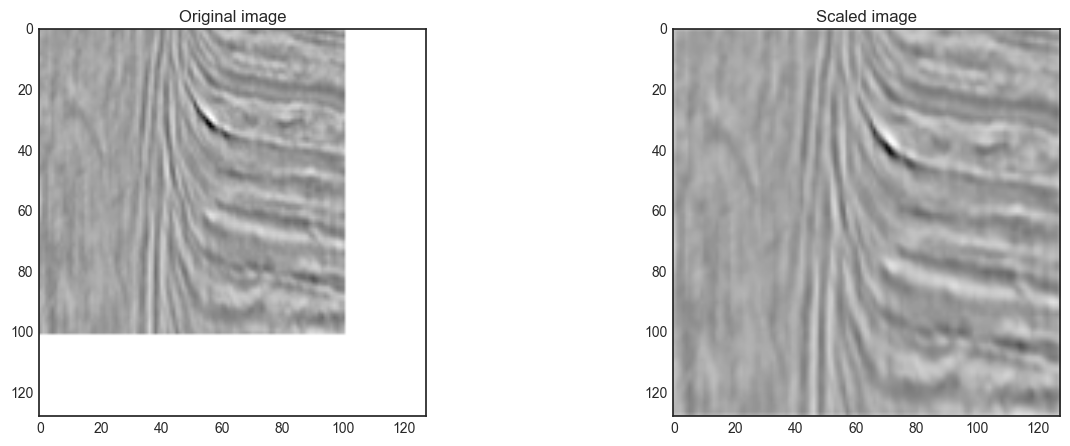

In [207]:
tmp_idx = 30
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[tmp_idx]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[tmp_idx]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[tmp_idx].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

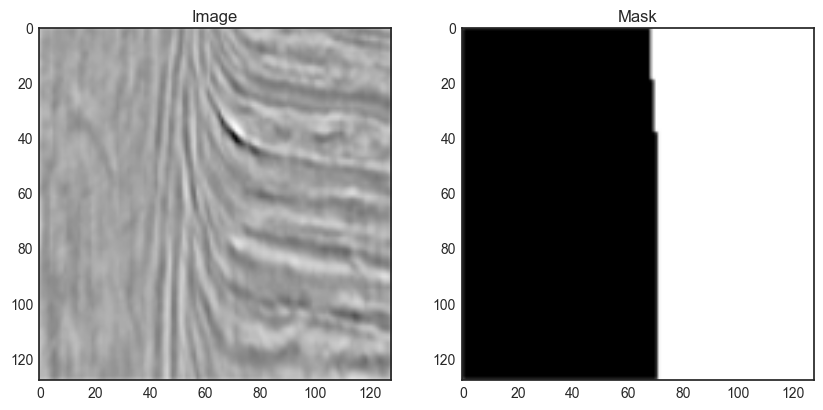

In [276]:
tmp_idx = 30

img = x_train[tmp_idx]
mask = y_train[tmp_idx]

img_mask_plot(x_train[tmp_idx],y_train[tmp_idx])



# Build model

In [68]:
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [69]:
model = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True)

In [70]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [71]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

# Data augmentation

In [127]:
x_train = np.append(x_train, [np.fliplr(y) for y in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(y) for y in y_train], axis=0)

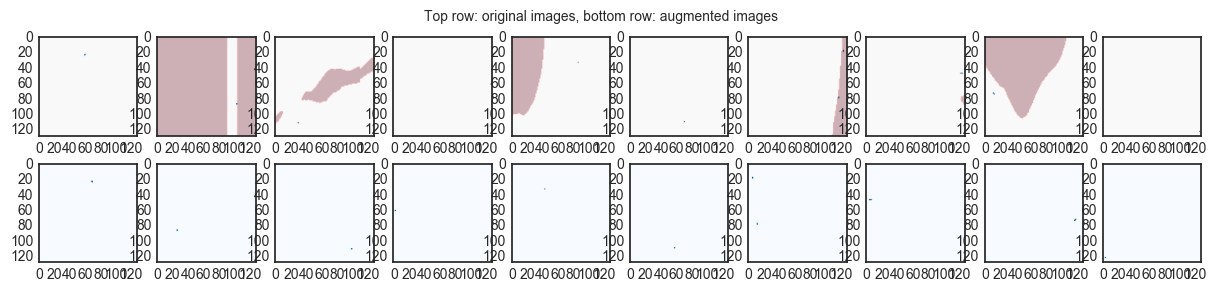

In [133]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Blues")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Reds", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Blues")
    #axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Reds", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

In [ ]:
x_train = np.append(x_train, [np.flipud(y) for y in x_train], axis=0)
y_train = np.append(y_train, [np.flipud(y) for y in y_train], axis=0)

In [ ]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

# Training

In [ ]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],shuffle=True)

In [ ]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")

0.378   0.380   0.380-2 0.728   0.738   0.752   0.758   0.761   0.774


In [196]:
#model = load_model("./keras.model")
model = load_model("../submissions/0.758/keras.model")

# Predict the validation set to do a sanity check
Again plot some sample images including the predictions.

In [197]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

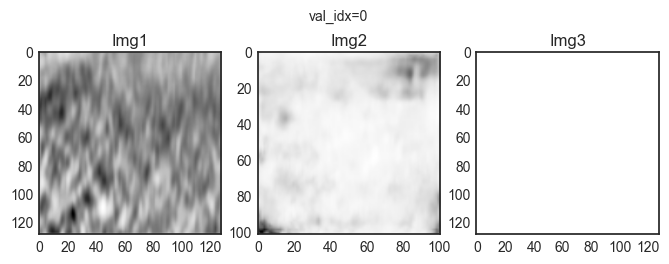

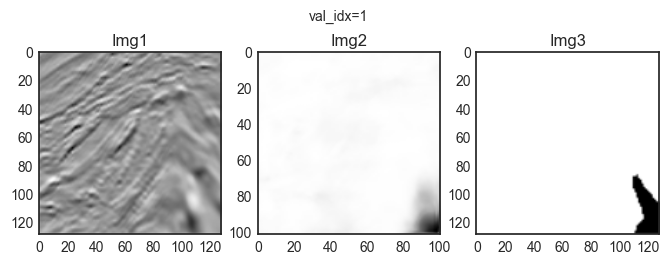

In [328]:
for val_idx in range(2):
    img_3_plot(x_valid[val_idx],preds_valid[val_idx],y_valid[val_idx],tit="val_idx="+str(val_idx))

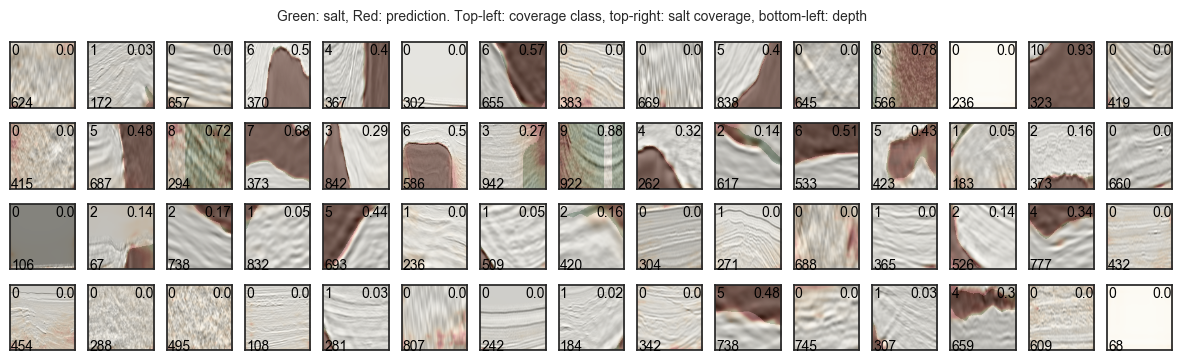

In [229]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Scoring
Score the model and do a threshold optimization by the best IoU.

In [331]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [334]:
val_score = pd.DataFrame(index=range(preds_valid.shape[0]),columns=['iou','prec'])
m = iou_metric_batch(y_valid_ori,preds_valid)
print(m)

0.404375


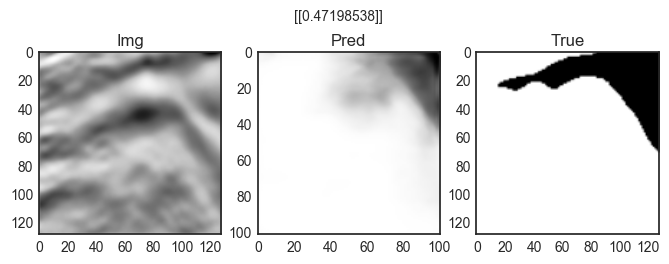

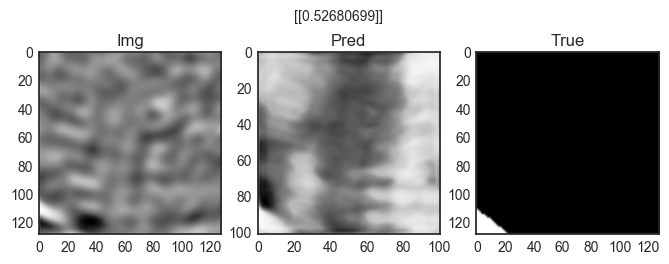

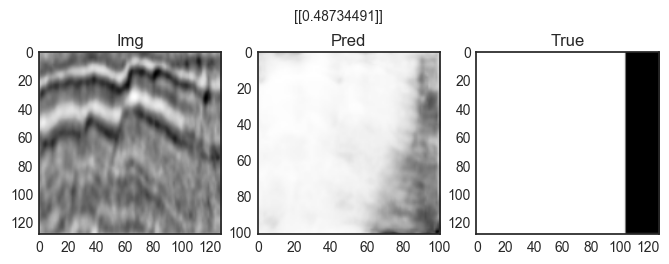

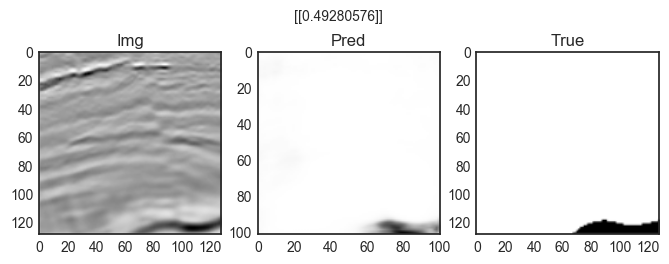

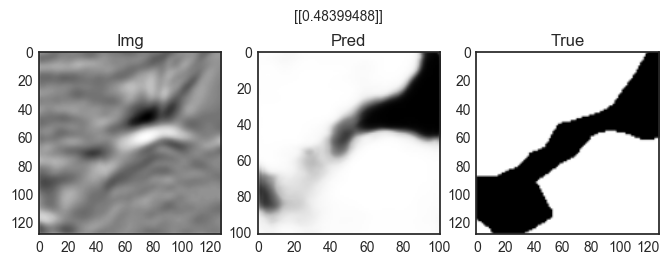

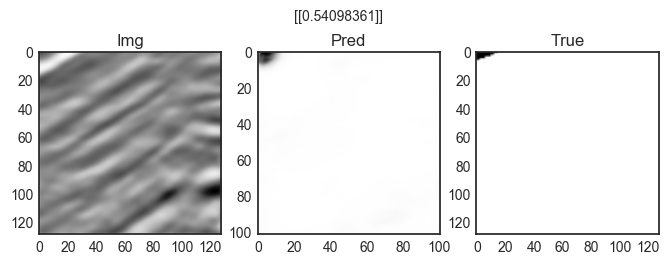

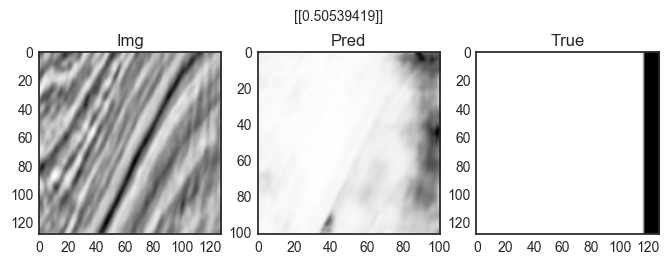

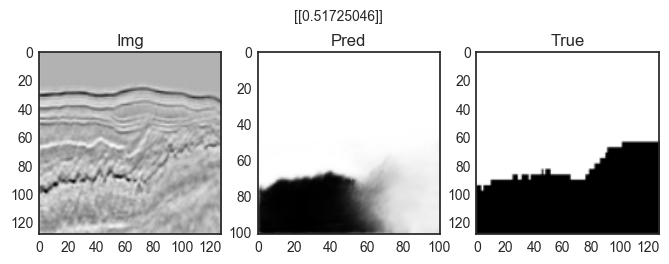

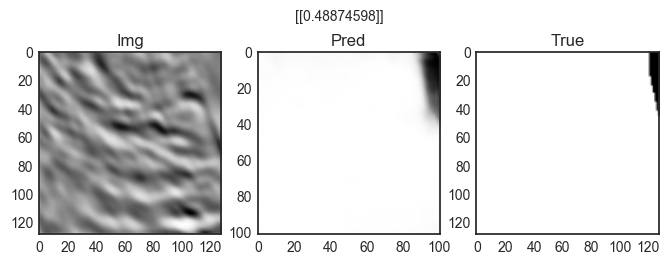

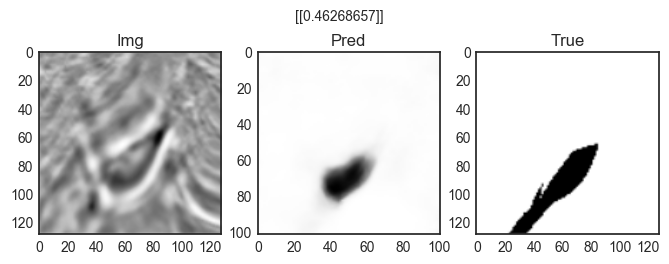

In [329]:
low_score_idx = val_score[np.abs(0.5-val_score.score)<0.05][0:10].index

for val_idx in low_score_idx:
    img_3_plot(x_valid[val_idx],preds_valid[val_idx],y_valid[val_idx],tits=["Img","Pred","True"],tit=val_score.score[val_idx])

In [335]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

HBox(children=(IntProgress(value=0, max=50), HTML(value=u'')))

In [336]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

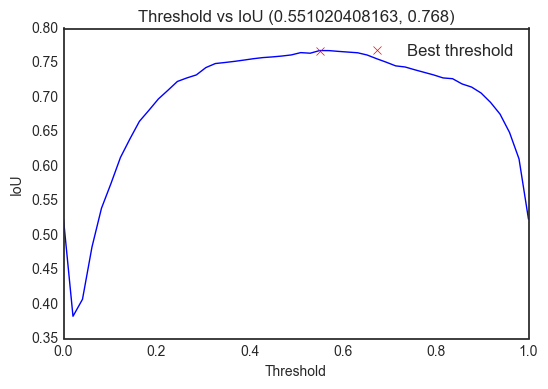

In [337]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [472]:
# Let's evaluate the iou and precision between:
# y_valid, preds_valid
# threshold to define the predicted mask: 0, 1
thr = threshold_best
tmp = []
for thr in np.arange(0.40,0.75,0.02):
    pred_mask_valid = np.array(np.round(preds_valid > thr), dtype=np.float32)
    ious = iou_clean_batch(y_valid_ori,pred_mask_valid)
    precs= prec_clean_batch(y_valid_ori,pred_mask_valid)
    coefs = np.zeros(ious.shape)
    coefs[ious>=0.50] = 0.1
    coefs[ious>=0.55] = 0.2
    coefs[ious>=0.60] = 0.3
    coefs[ious>=0.65] = 0.4
    coefs[ious>=0.70] = 0.5
    coefs[ious>=0.75] = 0.6
    coefs[ious>=0.80] = 0.7
    coefs[ious>=0.85] = 0.8
    coefs[ious>=0.90] = 0.9
    coefs[ious>=0.95] = 1.0
    value = np.mean(precs*coefs)
    tmp.append(value)
    print(value)


0.7161048831071304
0.7160409176736883
0.7161277389945901
0.7181772446968212
0.7190448373733305
0.7220682418902132
0.7251149333493058
0.7250654084652814
0.7267403972111811
0.7267663948157499
0.7249809458180249
0.7253780881021024
0.7232482797860349
0.7195119698985931
0.7148379269566567
0.7098799049534407
0.706422586389095
0.7033866504063687


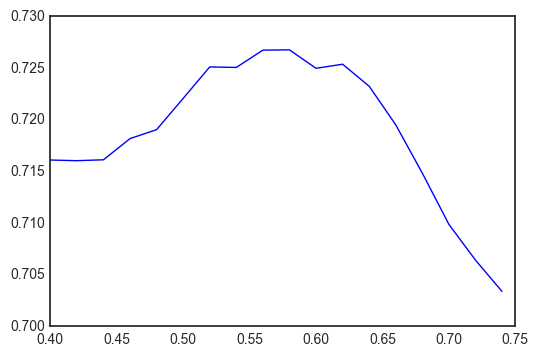

In [473]:
plt.plot(np.arange(0.40,0.75,0.02),tmp)



0.384012539184953
0.384012539184953


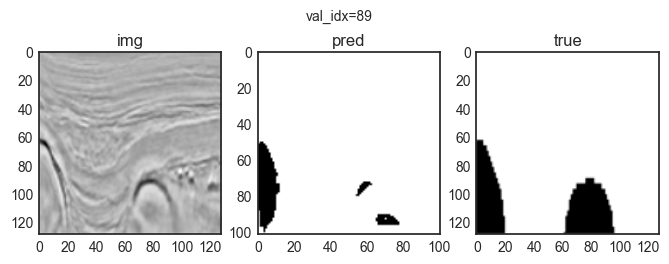

In [446]:
ix = 89
p = prec_clean(y_valid_ori[ix],pred_mask_valid[ix])
io = iou_clean(y_valid_ori[ix],pred_mask_valid[ix])

print(p)
print(io)

img_3_plot(x_valid[ix],pred_mask_valid[ix],y_valid[ix],tit="val_idx="+str(ix),tits=["img","pred","true"])

# Another sanity check with adjusted threshold
Again some sample images with the adjusted threshold.

In [ ]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Submission
Load, predict and submit the test image predictions.

In [ ]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [ ]:
x_test = np.array([upsample(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [ ]:
preds_test = model.predict(x_test)

In [ ]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')